# **SMS Spam Detection, NLP Project**

In this Jupyter Notebook, we present a comprehensive analysis and implementation of an SMS spam detection system using Natural Language Processing **(NLP)** techniques. The objective of this project is to create a Machine-Learning model capable of distinguishing between legitimate text messages and spam messages.

**NLP (Natural Language Processing)** is a subset of AI that allows machines to understand human language. NLP allows for open communication between complex humans and machines  ( Machines can only understand 0's and 1's (Binary)).


##**0. Installing and Importing Dependencies**

In [1]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score
from sklearn import metrics

#plot_confusion_matrix is now deprecated, using ConfusionMatrixDisplay

##**1. Importing the Data**

In [2]:
df = pd.read_csv("spam.csv", encoding="latin-1")

##**2. Cleaning the Data**

Data cleaning is an essential process before we analyze/model the data.

**Noisy Data:** Data in the dataset that contains errors, outliers, or irrelevant information
Noisy Data can occur for a multitude of reasons:

1.   Human Error during data collection/data entry
2.   Data corruption, + many more reasons.



***Benefits of Data Cleaning:***

*   **Improved Model Performance:** If we do not clean our data, which sums up to allowing noisy data to infiltrate the clean data, this can affect the ability of the machine to miss important patterns in the data, resulting in lower model accuracy.
*   **Reduced Training Time:** Data cleaning also allows for faster training time. The model will not have to spend as much time processing the unclean/noisy data.

*   **Improved Interpreability:** Cleaned data allows for much more interpretable data, which is helpful when debugging the model, code, and data.
*   **Better Generalization:** Cleaned Data allows the model to generalize better to new data. This is because, through data cleaning, the model is more likely to have been trained on a wider range of patterns, and will be less likely to overfit to training data.





In [3]:
df.dropna #Removing any N/A / Missing values out of the dataset, so our data is as clean as possible

<bound method DataFrame.dropna of         v1                                                 v2 Unnamed: 2  \
0      ham  Go until jurong point, crazy.. Available only ...        NaN   
1      ham                      Ok lar... Joking wif u oni...        NaN   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3      ham  U dun say so early hor... U c already then say...        NaN   
4      ham  Nah I don't think he goes to usf, he lives aro...        NaN   
...    ...                                                ...        ...   
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham              Will Ì_ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...any other s...        NaN   
5570   ham  The guy did some bitching but I acted like i'd...        NaN   
5571   ham                         Rofl. Its true to its name        NaN   

     Unnamed: 3 Unnamed: 4  
0           NaN        N

##**3. Exploratory Data Analysis**

In [4]:
df.head() #Viewing the top of the dataset

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


**Renaming the columns of the dataset. I want to make the code more readable and clearer, the columns "v1 & v2" on the current dataset won't do the job.**


In [5]:
df.rename(columns = {"v1":"Target", "v2": "Text"}, inplace = True) #inplace = True allows us to modify the Dataframe in place, meaning that changed to the column names are applied directly to the original Dataframe without any need to assign the result to a new variable

**Visualizing how the dataset through a bar chart, since the dataset is classified either as Ham (Non-Spam E-mail) or Spam (Email that is Spam)**

Text(0, 0.5, 'Number of Data points')

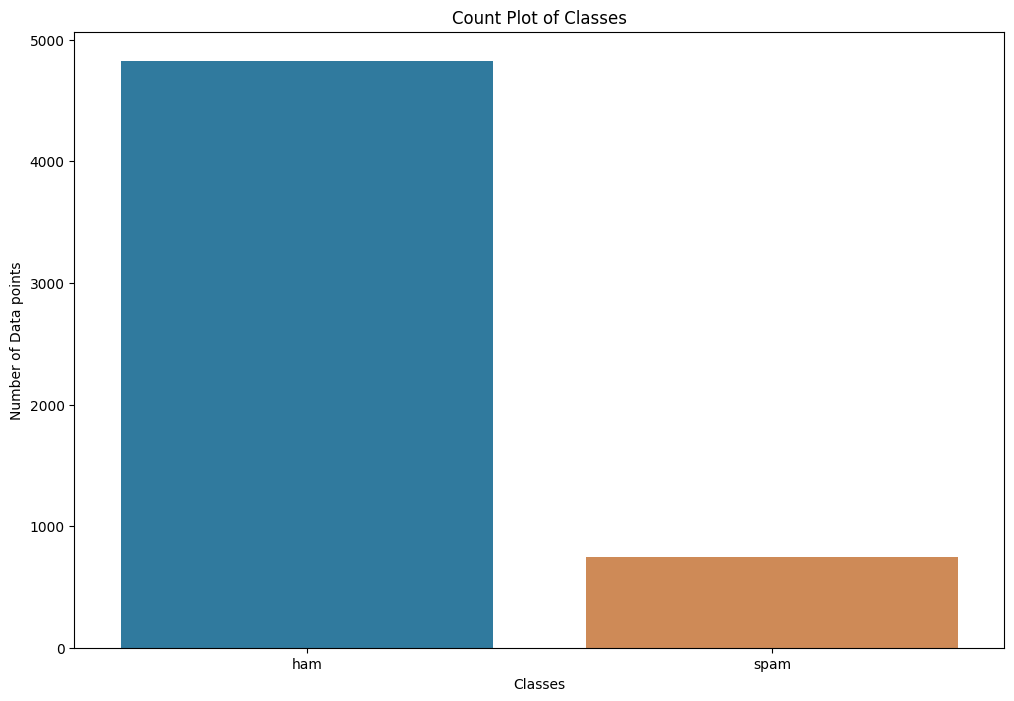

In [6]:
#Palette
cols= ["#1e81b0", "#e28743"] #Bar chart coloring
plt.figure(figsize=(12,8))
fg = sns.countplot(x = df["Target"], palette= cols) #target
fg.set_title("Count Plot of Classes", color="#000000") #Title of the barchart
fg.set_xlabel("Classes", color="#000000") #labels of barchart
fg.set_ylabel("Number of Data points", color="#000000") #labels of barchart

##**Feature Engineering**

Feature Engineering is the process of selecting, manipulating, and transforming raw data into features that can be used in supervised learning.

**New features being created**,

*   **NO_of_Characters**: Number of characters in an E-mail/text message
*   **NO_of_Words**: Number of words in the E-mail/text message
*   **NO_of_sentences**: Number of sentences in the E-mail/text messages.

Now, we are downloading the Punkt tokenizer from the Natural Language Toolkit (NLTK) data repository which I imported at the top of this notebook. The Punkt tokenizer is a statistical sentence boundary detection algorithm that can be used to split text into sentences.

The Punkt tokenizer is trained on a lot of text, and it learns to identify sentence boundaries based on a variety of features, such as punctuation, capitalization, and word collocations. Once the Punkt tokenizer is trained, it can be used to split any text into sentences, regardless of the language.

The Punkt tokenizer is a valuable tool for many natural language processing (NLP) tasks, such as text classification, sentiment analysis, and machine translation. Also being used in many popular NLP libraries, such as spaCy and TextBlob.

In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

**Creation of the new features**

In [8]:
df["NO_of_Characters"] = df["Text"].apply(len) #Creating the new column in the dataframe called NO_of_Characters

#nltk.word_tokenize() function allows us to split a string into a list of words
df["NO_of_Words"] =df.apply(lambda row : nltk.word_tokenize(row["Text"]), axis=1).apply(len) #Creating the new column called NO_of_Words, the apply() dunction being used to applt the nltk.word_tokenize() function to each row of the dataframe.

df["NO_of_sentences"] = df.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len)

df.describe().T #Analyzing the distribution and overview of the dataframe

#The T in data.describe().T is the transpose function in Pandas. Transposing a DataFrame, meaning that it swaps the rows and columns.

,count,mean,std,min,25%,50%,75%,max
NO_of_Characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
NO_of_Words,5572.0,18.699390,13.741932,1.0,9.0,15.0,27.0,220.0
NO_of_sentences,5572.0,1.996411,1.520159,1.0,1.0,1.5,2.0,38.0


**Visualizations**

<Figure size 1200x800 with 0 Axes>

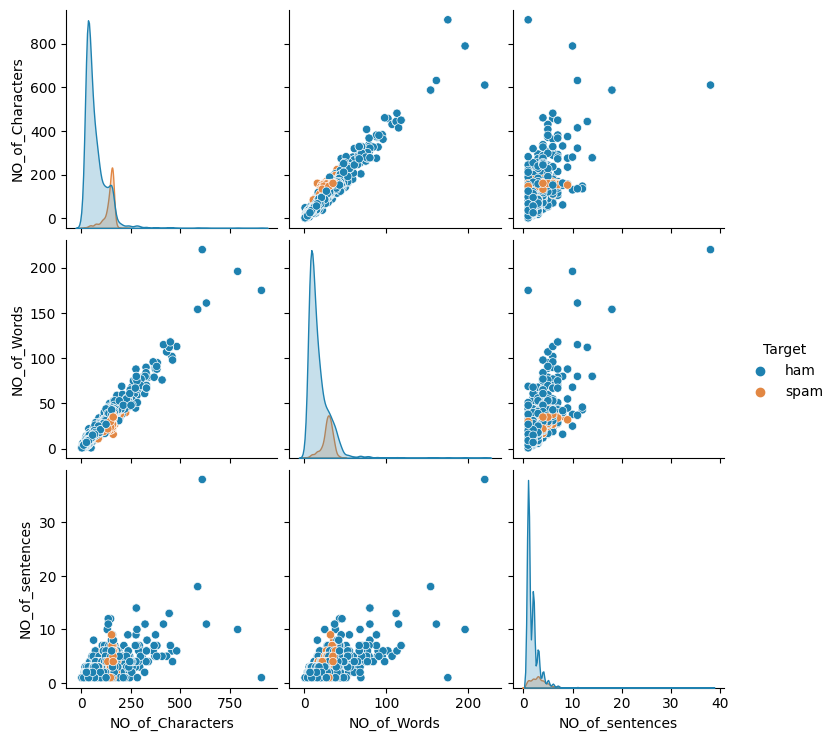

In [9]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(df, hue="Target", palette=cols)
plt.show(fg)

From what we see, our seaborn pairplot allows us to see the outliers of the class "**Ham**" (**Ham** = *E-mail that is not spam*).

Here are the main reasons why are analyzing and dropping the outliers in the class of Ham.

* **Outliers can skew the results of our ML model:** ML algorithms are usually trained on large amounts of data points, and outliers can impact our overall results. (Eg. If I'm trying to train a model that can predict the price of a house, leaving a few super-expensive homes that are outliers in the dataset can make model predictions less accurate/realistic.)

* **Outliers make it difficult for ML models to generalize to newer data:** ML algorithms learn to identify patterns in the data, and outliers can easily disrupt that due to their anomalous nature.




##**Outlier Detection**

**Dropping the outliers**

In [10]:
#Dropping the outliers

df = df[(df["NO_of_Characters"]<350)] #Filters the dataframe, to only include rows where the NO_of_Characters column is less than 350. Removing any rows where the value in the NO_of_Characters column is an outlier.
df.shape #Printing the updated shape of the dataframe, which is the number of rows and columns in the dataframe.

(5548, 8)

**Visualizations**

<Figure size 1200x800 with 0 Axes>

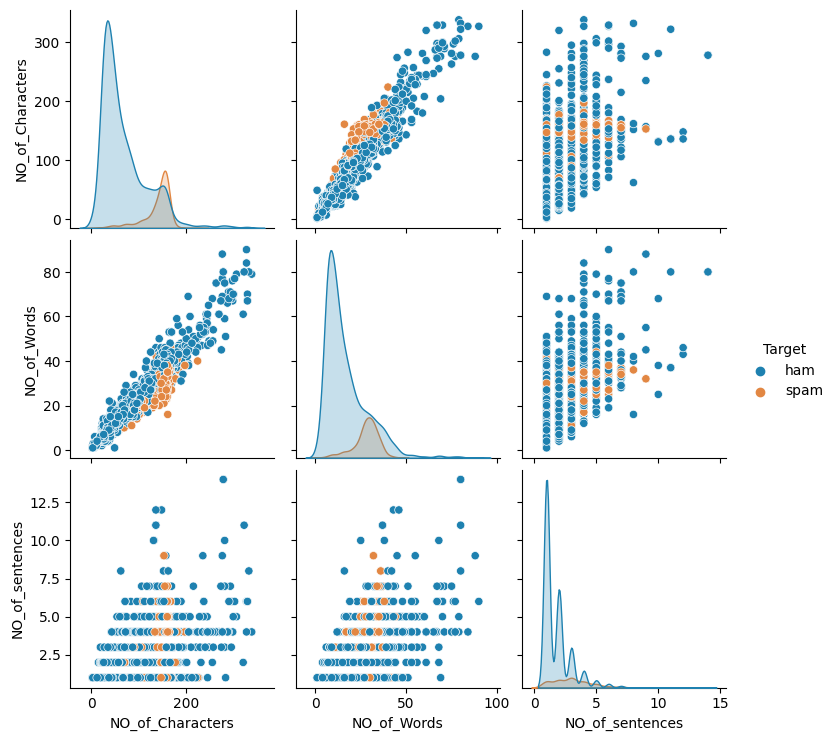

In [11]:
plt.figure(figsize=(12,8)) #plt.fgure creates the figure window, figsize(12,8) specifies the size of the figure window in inches
fg = sns.pairplot(df, hue="Target", palette=cols) #hue="Target" specifies that the target variable should be used to color the points in the scatter plots, palette=cols specifies the color palette should be used to color points in the scatter plots
plt.show(fg)

## **Data Pre-Processing**

### **NLP Text Pre-Processing Techniques**

**Here are the next steps of our project.**

1.   **Cleaning the Text**: Removing any *Noise*
(***Noise:*** Unwanted Data that can often cause the Algorithm to miss out patterns in data, interfering with the learning process of a model negatively.)
2.   **Tokenization**: Process of splitting a text string into smaller units, such as words, punctuation marks, and white space. This is an important step in Natural Language Processing (NLP), this allows for the computer to comprehend/understand the structure of the text and the relationships between the different words.
3.   **Removing Stopwords**: If you do not know, stopwords are often common words that occur frequently in Messages/E-mails/Text Messages. Examples include "**the**", "**is**", "**of**", or "**to**". Removing stopwords can help the performance of our Natural Language Processing (NLP) tasks. This allows the computer to focus on the important words to identify.
4.   **Lemmatization**: The process of converting words to their base form/root, or lemma. The stemming of words and Lemmatization are not that different, the point of Lemmatization is to reduce words to their given root. For example, "running", "ran" and "runs" all have the same lemma, "run". The reason why we are using Lemmatization is so the computer can understand that all of these words have the same meaning, even if they are in different forms.




### **Cleaning the Text**

**Step 1:** Extracting the alphabetic characters, in doing this, we will need to remove the punctuation and numbers.

 **Step 2:** Converting all of the characters into lowercase.



**Printing out the 5 first Text Messages to the console**

In [12]:
#Analyzing/Printing out the first 5 messages/text messages in the dataframe to the console, before beginning the cleanup process
print("\033[1m\u001b[45;1m The First 5 Text Messages:\033[0m",*df["Text"][:5], sep = "\n")

#\033[1m: Makes the following text bold.
#\#0000FF[45;1m: Changes background color of the following text to magenta.
#print() prints the specified arguments to the console.
#*df["Text"][:5] is an expression that evaluates to a list of the first 5 texts in the DataFrame df.
#sep = "\n" specifies that the elements of the list df["Text"][:5] should be separated by newline characters when they are printed to the console.

# Also, not neccesary but, fun fact, \033[0m: Resets the text formatting to the default.

 The First 5 Text Messages:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though


**Printing out the 5 First Text Messages to the console after cleaning**

In [13]:
#Defining a function to clean up the text messages
def Clean(Text):
  sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all the non-alphabetic characters with a space
  sms = sms.lower() #Converting the characters into lowercase
  sms = sms.split()
  sms = ' '.join(sms)
  return sms

df["Clean_Text"] = df["Text"].apply(Clean)
print("\033[1m\u001b[45;1m The First 5 Text Messages after cleaning:\033[0m", *df["Clean_Text"][:5], sep = "\n")

 The First 5 Text Messages after cleaning:
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


<ipython-input-13-5659bd6a33de>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Clean_Text"] = df["Text"].apply(Clean)


### **Tokenization**

Tokenization is simply breaking down/splitting complex data into smaller units called **"Tokens"**. Tokens can be represented as words, characters subwords etc. I will be splitting the Clean_Text into words in the step below this.

In [14]:
df["Tokenize_Text"]=df.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

print("\033[1m\u001b[45;1m The First 5 Text Messages after Tokenizing:\033[0m",*df["Tokenize_Text"][:5], sep = "\n")

 The First 5 Text Messages after Tokenizing:
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


<ipython-input-14-425be5c9ce8a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Tokenize_Text"]=df.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)


### **Removing Stopwords**

Stopwords are often common words that occur frequently in Messages/E-mails/Text Messages. Examples include "**the**", "**is**", "**of**", or "**to**". Removing stopwords can help the performance of our Natural Language Processing (NLP) tasks. This allows the computer to focus on the important words to identify. Now to be clear, in regular sentence structure these words glue and give sentences meaning, but are not useful to **Natural Language Processing (NLP)**.

Have to download the required NTLK package before using it.

In [15]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
# Removing the stopwords function
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

df["Nostopword_Text"] = df["Tokenize_Text"].apply(remove_stopwords)

print("\033[1m\u001b[45;1m The First 5 Text Messages after removing the stopwords:\033[0m",*df["Nostopword_Text"][:5], sep = "\n")

 The First 5 Text Messages after removing the stopwords:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


<ipython-input-16-56428c361c17>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Nostopword_Text"] = df["Tokenize_Text"].apply(remove_stopwords)


### **Lemmatization**

 **Lemmatization** is the process of reducing/converting words to their base form/root, or lemma. The stemming of words and Lemmatization are not that different, the point of Lemmatization is to reduce words to their given root. For example, "running", "ran" and "runs" all have the same lemma, "run". The reason why we are incorporating Lemmatization, is so the computer can understand that all of these words have the same meaning, even if they are in different forms.

Have to download the required NTLK package before using it.

In [17]:
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [18]:
lemmatizer = WordNetLemmatizer()

def Lemmatize_word(text):
  lemmas = [lemmatizer.lemmatize(word, pos ='v')for word in text]
  return lemmas

df["Lemmatized_Text"] = df["Nostopword_Text"].apply(Lemmatize_word)
print("\033[1m\u001b[45;1m The first 5 Text Messages after Lemmitization:\033[0m", *df["Lemmatized_Text"][:5], sep = "\n")

 The first 5 Text Messages after Lemmitization:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']


<ipython-input-18-3dbcea32fd6d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Lemmatized_Text"] = df["Nostopword_Text"].apply(Lemmatize_word)


### **Vectorization**

Vectorization in ML is the process of converting data into a numerical format that has the ability to be processed by ML algorithms. It's an important step throughout many ML pipelines, as it allows algorithms to efficiently perform mathematical operations on the data.

Vectorized Data is usually represented as a matrix, where each row represents a data instance and each column represents a feature.

In Natural Language Processing (NLP), there is a concept called **TF-IDF** (**Term Frequency - Inverse Document Frequency**). In Natural Language Processing (NLP) cleaned-up data needs to be converted into a numerical format where each word is represented by a matrix. This process is also known as **Word Embedding / Word Vectorization**.

**Here are some equations for Term Frequency (TF) & Inverse Document Frequency(IDF)**

* **Term Frequency (TF)** = (Frequency of a term in the document)/(Total number of terms in documents)

* **Inverse Document Frequency(IDF)** = log( (total number of documents)/(number of documents with term t))



**We will be using the "TfidfVectorizer()" to vectorize the preprocessed data.**

The TfidfVectorizer() is a class in the Sci-Kit Learn library that allows us to vectorize text data using the TF-IDF (Term Frequency - Inverse Document Frequency) metric.

The TfidfVectorizer() works by tokenizing the text data, which means splitting the text into individual words or phrases. It then calculates the TF-IDF score for each term in each document. It finally converts the TF-IDF scores into a sparse matrix, which is a matrix where most of the elements are zero.

Sparse matrixes can be used as powerful inputs for ML algorithms, for eg. training a text classifier or sentiment analyzer. (It's why we want to use it, it's great for NLP tasks)

**Main Steps in Vectorizing**


*   Creating a corpus for Lemmatized Text
*   Converting the corpus in Vector Form
*   Label Encoding the Classes in Target

In [19]:
corpus = [] #Creating a corpus from our dataset column, containing lemmatized text
for i in df["Lemmatized_Text"]: #The line iterates over the Lemmatized_Text column of the dataset
  msg = ' '.join([row for row in i]) #This line joins the individual words in the current row of "Lemmatized_Text" column into a single string using the join() function.The join() function takes a list of strings as input and returns a single string with the elements of the list separated by the specified delimiter. In this case, the delimiter is a space character.
  corpus.append(msg) #This line appends the sresulting strings to the corpus list

corpus[:5] #Selects the first 5 elements of the corpus list
print("\033[1m\u001b[45;1m The First 5 lines in corpus :\033[0m", *corpus[:5], sep = "\n") #Printing the first 5 elements of the corpus list to the terminal

 The First 5 lines in corpus :
go jurong point crazy available bugis n great world la e buffet cine get amore wat
ok lar joke wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think go usf live around though


In [20]:
tfidf = TfidfVectorizer() #Creating the TfidVectorizer obejct
X = tfidf.fit_transform(corpus).toarray() #This line vectorizes the corpus using tue TfidVectorizer object and returns a sparse matrix
X.dtype #Printing the dtype (dtype = datatype) of the dense array to the terminal

dtype('float64')

In [21]:
#Encoding the target column in the dataset using a LabelEncoder
label_encoder = LabelEncoder() #Creating a LabelEncoder object
df["Target"] = label_encoder.fit_transform(df["Target"]) #Encoding the target column in the dataset using the LabelEncoder object.

<ipython-input-21-8329675fb678>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Target"] = label_encoder.fit_transform(df["Target"]) #Encoding the target column in the dataset using the LabelEncoder object.


### **Model Building**

**Model Building** in ML (Machine Learning) is the process of creating a mathematical model that can be used to make predictions/decisions based on data you feed it.

**Steps Involved in our Model Building,**

1.   **Setting up features and targets as X & Y:** The first step includes preparing the data for modelling. This involves splitting the data into 2 sets. Features (X) and Target (y). The features are the input variables that the model will use to make predictions, and the target is the output variable that the model is trying to predict.

2.   **Splitting the Testing and Training tests:** Once the data has been split into features and targets, the next step is to split it into training and testing sets. The training set is used to train the model, and the testing set is used to evaluate the performance of the trained model.

3.   **Building an ML pipeline for the model, to train and evaluate 4 different types of ML Algorthims / Classifiers** (*Classifiers*: ML algorithm that is used to predict the class of a data point)

*   **Naïve Bayes:** Simple / Effective ML algorithm that is based on Bayes' theorem. Bayes' theorem is a mathematical formula that can be used to calculate the probability of an event occurring given the probability of other events occurring.

*   **RandomForestClassifier**: An ensemble learning algorithm (Ensemble learning is a machine learning technique that combines several base models in order to produce one optimal predictive model.) that combines the predictions of multiple decision trees to make a final prediction. Ensemble learning algorithms are often more accurate and precise than individual algorthims because ensemble learning is less likely to overfit the training data.

*   **KNeighborsClassifier**: ML algorithm that makes predictions based on the similarity of new data points to existing data points. This is a simple algorithm, but it can prove to be very effective when solving problems that involve high-dimensional data.

*   **Support Vector Machines**: ML algorithm that can be used for tasks like classification and regression. SVM's work by creating a hyperplane in the feature space that separates the data points into 2 classes.

4. **Fit all of the models into the training data:** Fitting all 4 classifiers into the training data and allowing it to learn the underlying patterns in the data.


5. **Getting the cross-validation on the training sets for all of the models, for Model Accuracy:** Cross-validation is a technique that is used to evaluate the performance of an ML model on unseen data. In cross-validation, the training data is split into multiple folds, and each fold is used to train the model and evaluate its performance on the remaining folds.



In [22]:
y = df["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
classifiers = [MultinomialNB(), RandomForestClassifier(), KNeighborsClassifier(), SVC()]

for cls in classifiers:
  cls.fit(X_train, y_train)

pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours",3: "SVC"}

In [24]:
for i, model in enumerate(classifiers):
  cv_score = cross_val_score(model, X_train, y_train, scoring="accuracy", cv=10)
  print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.967552 
RandomForest: 0.973635 
KNeighbours: 0.911450 
SVC: 0.974086 


### **Evaluating Models**

**This section of code evaluates the performance of our 4 four different Machine Learning Models:**

*   **Naive Bayes**
*   **Random Forest**
*   **K-Neighbors**
*   **Support Vector Machine**

**Our Model evaluations will done by calculating the following:**

*   **Precision:** The fraction of true positives among all predicted positives. True positives are the cases where the model correctly predicted a positive outcome.

*   **Recall:** Recall is the fraction of true positives among all positives. False negatives are the cases where the model incorrectly predicted a negative outcome.
*   **F1 Score:** F1 score is a useful/helpful metric to help us evaluate the performance of our ML model because it takes into account both precision and recall. It's a Harmonic Mean OF precision and recall. (**Harmonic Mean:** One of several kinds of average)
*   **Accuracy on the Testing Set:** Percentage of correct predictions on the testing set (**Testing Set:** Subset of the data to test the trained model)
*   **Accuracy on the Training Set:** Percentage of correct predictions on the training set (**Training Set:** Sample/Subset of the data used to fit and train the model)







**Vocabulary to Know**:


*   **Positives** - Data points that have a positive label. For example, in our spam NLP (Natural Language Processing) task, positives are the types of emails that are spam, it's the data we want to identify/filter out.
*   **Negatives** - Data points that have a negative label. For example, in our spam NLP (Natural Language Processing) task, negatives are the emails that are not spam.

*   **Appending** - The process of attaching or combining data with another file or set of data.



**We will also look to derive 2 types of evaluations from our models using,**

1.   **Accuracy Report** - A type of classification metric that allows us to evaluate the performance of our text classification model. It derives information like


*   **Accuracy:** Showing us correctly predicted data points
*   **Precision:** The fraction of predicted positives that are actually positive.

*   **Recall:** The fraction of actual positives that are correctly predicted
*   **F1 Score:** A harmonic mean of precision and recall.

2.   **Confusion Matrix** - Table that shows the number of actual positives, actual negatives, predicted positives and predicted negatives for a given model.

In [25]:
#Creating emplty lists to store the precision, recall, F1 Score, training set accuracy and test set accuracy, for each classifier.
precision = []
recall = []
f1_score = []
trainset_accuracy = []
testset_accuracy = []

#Created a for loop so I could iterate over the classifiers
for i in classifiers:
  pred_train = i.predict(X_train) #This line here predicts the labels of the training data using the current classifier.
  pred_test = i.predict(X_test)  #This line here predicts the labels of the test data using the current classifier.
  prec = metrics.precision_score(y_test, pred_test) #Calculating the precision using the Sci-Kit metrics module
  recal = metrics.recall_score(y_test, pred_test) #Calculating the recall values using the Sci-Kit metrics module.
  f1_s = metrics.f1_score(y_test, pred_test) #Calculating the f1 values using the Sci-Kit metrics module.
  train_accuracy = model.score(X_train, y_train) #Calculating the training set accuracy using the Sci-Kit score method
  test_accuracy = model.score(X_test, y_test) #Calculating the testing set accuracy using the Sci-Kit score method

  precision.append(prec) #Appending (The process of attaching or combining data with another file or set of data) the calculated precision
  recall.append(recal)  #Appending the calculated recall
  f1_score.append(f1_s) #Appending the calculated f1 score
  trainset_accuracy.append(train_accuracy) #Appending the calculated training set
  testset_accuracy.append(test_accuracy) #Appending the calculated testing set

In [26]:
df = {'Precision':precision, #Creating a dictionary to store the results of the precision, recall, f1, training set and testing set.
  'Recall':recall,
  'F1score':f1_score,
  'Accuracy of Testset':testset_accuracy,
  'Accuracy of Trainset':trainset_accuracy}

Results = pd.DataFrame(df, index=["NaiveBayes", "RandomForest", "KNeighbours", "SVC"]) #Creating a pandas df from the dictionary created above

In [27]:
cmap2 = ListedColormap(["#000080", "#FFA500"]) #Creating a colormap
Results.style.background_gradient(cmap=cmap2) #Applies a background gradient to the pandas df, using the custom colormap

,Precision,Recall,F1score,Accuracy of Testset,Accuracy of Trainset
NaiveBayes,1.000000,0.705882,0.827586,0.974775,0.997521
RandomForest,1.000000,0.823529,0.903226,0.974775,0.997521
KNeighbours,0.977778,0.323529,0.486188,0.974775,0.997521
SVC,0.990909,0.801471,0.886179,0.974775,0.997521


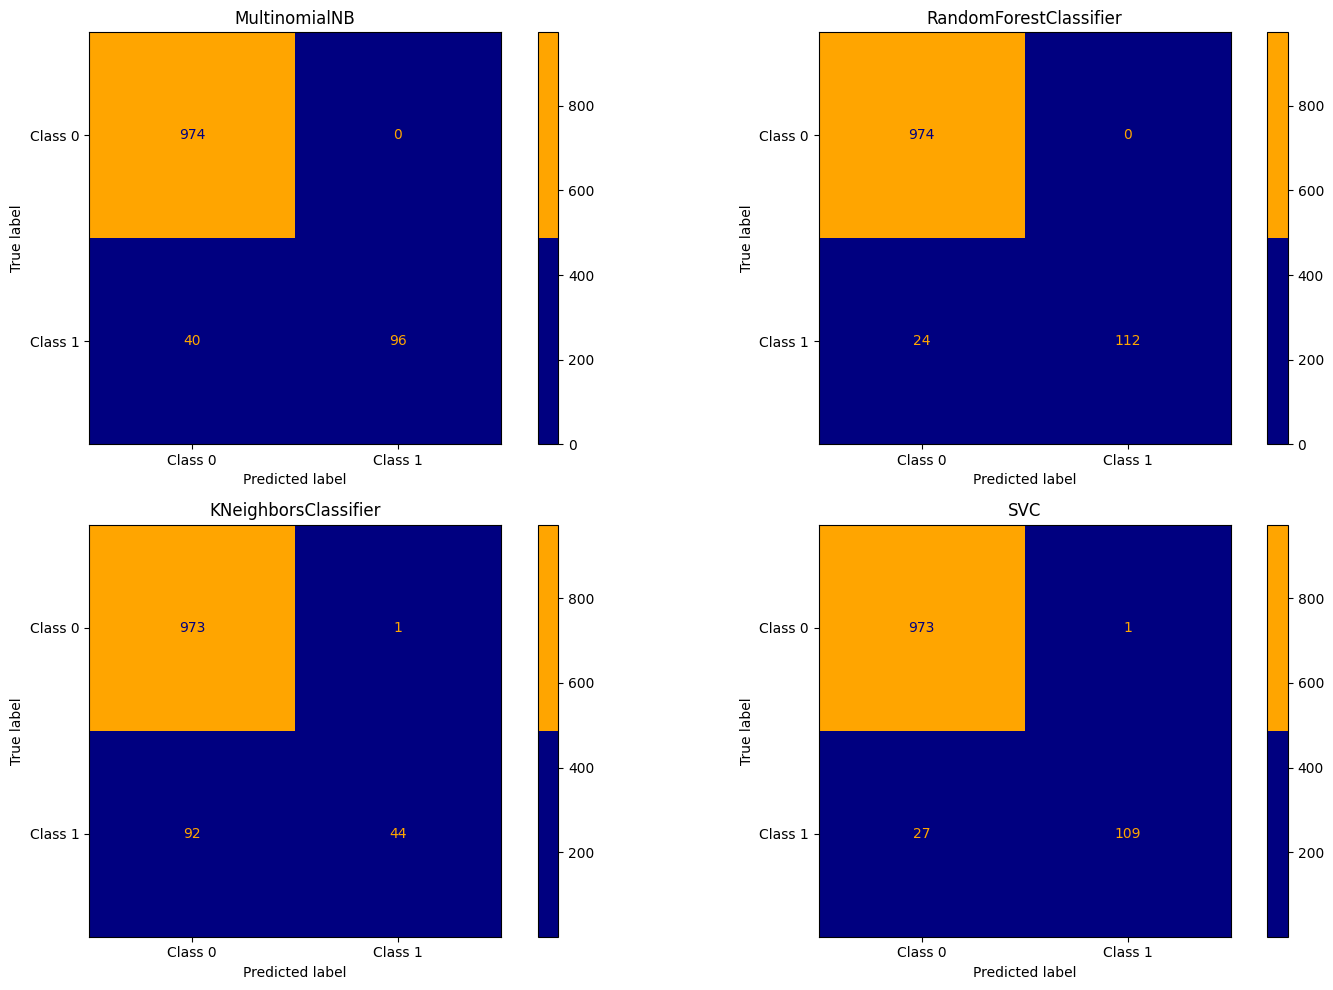

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cmap = ListedColormap(["#000080", "#FFA500"]) #Creating custom colormap
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10)) #Creating a figure and axes using the plt.subplots() function. Creating a figure that has 2 rows and 2 columns, figure size being 15 by 10 inches

#Iterating over the classifiers, and for each classifier, the for loop assigns the current classifier to the variable cls and the current axis variable to ax
for cls, ax in zip(classifiers, axes.flatten()):
    y_pred = cls.predict(X_test)  # Use the classifier to make predictions on test data
    cm = confusion_matrix(y_test, y_pred)  # Calculating the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1']) #Creating a ConfusionMatrixDisplay object using the confusion matrix and the display labels called Class 0 and Class 1
    disp.plot(cmap=cmap, ax=ax) # This line allows us to plot the confusion matrix using the ConfusionMatrixDisplay.plot() method.
    ax.set_title(type(cls).__name__) # Setting the title of the axis to the name of the ML classifier

plt.tight_layout()  #adjusting the layout of thr figure
plt.show() #displaying figure

### **Sources that helped us build this project:**

1.   **https://www.kaggle.com/code/karnikakapoor/spam-or-ham-sms-classifier#SPAM-OR-HAM**
2.   **Google Bard**



### **Conclusion**

In this notebook, we built a spam filter using a variety of natural language processing (NLP) techniques. We first cleaned and preprocessed the data, including removing punctuation, converting all characters to lowercase, and removing stop words. We then used lemmatization to reduce words to their root form.

Next, we trained and evaluated several machine learning models, including Naive Bayes, Random Forest, and K-Nearest Neighbors. We found that the Random Forest model performed the best, with an accuracy of 97%.

**Limitations and future work**

One limitation of our study is that we only used a small dataset of SMS messages. In the future, I would like to train and evaluate the models on a larger and more diverse dataset.

Another limitation is that we only considered a few NLP techniques. In the future, I would like to explore other techniques, such as word embedding and sentiment analysis, to improve the performance of our model.

Overall, our results show that NLP techniques can be used to build effective spam filters.

**Thank you!**